# 1. Introduction

## 1.1 What are we doing?

We're doing a little interactive project to give you a better feel for how LIGO data analysis actually works.  In particular, we'll be doing **matched filtering** of some data.

You can kind of think of LIGO as a really sensitive microphone, and the data that comes out is like a sound recording.  (Except, of course, that sound requires air, while gravitational waves travel through spacetime itself.)  In fact, if you go to the LIGO control room, they'll often play the data over speakers, because this is a really useful way of thinking about it.  It even happens to be in the right range for human hearing.  So we'll be listening to LIGO data and gravitational waveforms.

But that will just be one of the data-analysis techniques we use.  We'll be looking at Fourier transforms, and introducing matched filters.  Finally, we'll do the some actual LIGO data analysis with some real (simulated) gravitational waveforms and LIGO data.

## 1.2 What are we looking at?

This is a [Jupyter notebook](https://jupyter.org/) (until recently, known as an [IPython notebook](http://ipython.org/notebook.html)).  It's connected to an actual python session, but it runs through a web browser, so we can format things nicely and give some explanations, and so you don't have to copy-and-paste all the instructions into a normal python session.  It's meant to look and work like Mathematica, if you've ever used that before.  (And if you don't care for python, Jupyter also handles [Julia](http://nbviewer.ipython.org/url/jdj.mit.edu/~stevenj/IJulia%20Preview.ipynb), [R](https://github.com/IRkernel/IRkernel), [IDL](https://github.com/lstagner/idl_kernel), and numerous other languages.)

Each of the sections in gray with something like "`In[1]:`" in front of it is called a *cell* and contains code for you to run.  Run the code by placing your cursor in the cell, then pressing Shift+Enter.  First, we'll load a few necessary packages that set up python to run the rest of our code:

In [1]:
# Set up matplotlib and numpy
%pylab inline
mpl.rcParams['figure.figsize'] = 12,8

# Don't use svg for plots with lots of points
%config InlineBackend.figure_format='png'

# This lets us write prettier things
from IPython.display import Latex, display

# Utils is a custom package with nice matched-filtering stuff
import Utils

# A couple convenient constants we'll use
SamplingFrequency = 8192.0
DistanceInMegaparsecs = 50.0

Populating the interactive namespace from numpy and matplotlib


You won't be expected to understand the python code (though if you do, that's great).  But you should run it, follow along with the explanations, and try to understand all the plots and sounds.

If you put your cursor in a text section and something weird happens, just put the cursor back in a gray box, and everything will be okay.

<br /><br />

# 2. Listening to gravitational waves

We've have some pre-made waveforms for you to experiment with.  We'll create a couple functions to read them in from the disk, then scale them to simulate a signal from $10\,$Mpc away, and for a range of masses.  To define the functions, run this cell:

In [2]:
def NonspinningGW(MassInSolarMasses, DistanceInMegaparsecs=DistanceInMegaparsecs):
    if(MassInSolarMasses<5.0):
        raise ValueError("The mass {0:.8g} is too small".format(MassInSolarMasses))
    return Utils.Waveform('Data/rhOverM_EqualMassNonspinning_L2_M2.dat',
                          SamplingFrequency, MassInSolarMasses, DistanceInMegaparsecs)
def SpinningGW(MassInSolarMasses, DistanceInMegaparsecs=DistanceInMegaparsecs):
    if(MassInSolarMasses<5.0):
        raise ValueError("The mass {0:.8g} is too small".format(MassInSolarMasses))
    return Utils.Waveform('Data/rhOverM_EqualMassAlignedSpins_L2_M2.dat',
                          SamplingFrequency, MassInSolarMasses, DistanceInMegaparsecs)

So now we have two functions to create waveforms, one for non-spinning waveforms and one for spinning waveforms.  So, for example, we can create the non-spinning waveform with a total mass of 5 solar masses as `NonspinningGW(5)`.  You shouldn't put in a mass smaller than 5 (because the data wasn't designed for that), but you can certainly put in far higher masses if you wish.  Also, you can optionally ask for the waveform to be scaled to a particular distance; we use $10\,$Mpc by default.

Next, we want to look at the data.  The data itself represents the amount of motion the mirrors in the detector experience, and they are given as a function of time.  So we can just plot the data:

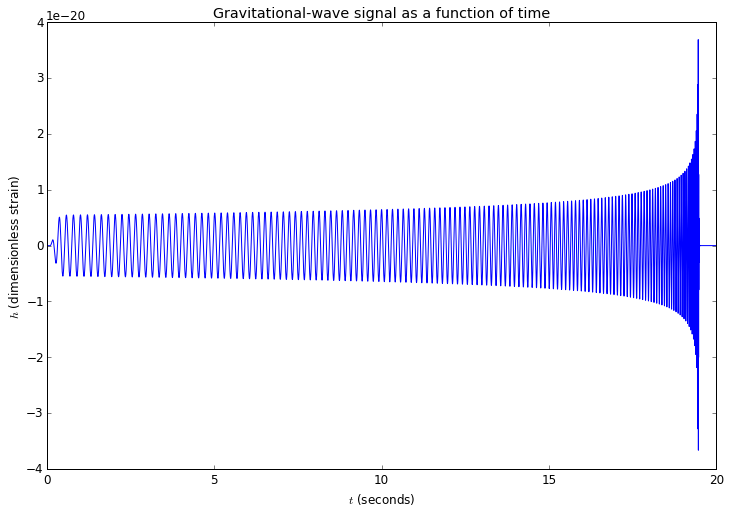

In [3]:
W = NonspinningGW(100.0)
plot(W.t, W.data)

xlabel(r'$t$ (seconds)')
ylabel(r'$h$ (dimensionless strain)')
title(r'Gravitational-wave signal as a function of time');

We notice a few important features:

  - The amplitude is shut off entirely at the beginning, but quickly turns on.  This is done for technical reasons (to get rid of the so-called Gibbs phenomenon -- but don't worry about it).  Of course, a real gravitational-wave signal would extend fairly regularly very far back in time.
  - The amplitude is slowly growing at first, but accelerates to a peak, and then basically shuts off again.  This part is real.  That's the merger and ringdown, where the black holes give off the strongest gravitational waves just as they fall into each other, which happens very suddenly.
  - The frequency is slowly increasing at first, but accelerates up to the merger.  This is another effect of the inspiral; as energy is given off in gravitational waves, the black holes spiral inwards toward each other and go faster and faster.

Now, we can also imagine this data as if it describes sound waves, where the plot we just made shows the displacement of the air as a function of time.  In fact, it's quite easy to turn this into a sound.  Evaluate the cell below, and press the play button.

***NOTE:*** Be careful of your ears.  If you can hear the long inspiral at all, the merger will probably sound extremely loud, so be prepared to turn down the volume near the end, or move your headphones away from your ears.

In [4]:
SpinningGW(5.0).Audio()

Notice that the plot we made was for a system of total mass 100 times the mass of the sun, but the sound was for a system of just 5 solar masses.  Play around with different values in the plot and the audio to answer these questions:

## Questions

- Can you *hear* the features that you saw in the plot?
  - How do those features change as you change the mass?  Amplitude?  Frequency?  Rate of change of amplitude and frequency?
  - Can you hear or see any differences between spinning and non-spinning systems?
  - What would happen if you changed the distance at which the system was located?

<br /><br />

# 3. The sound of the detector

Unfortunately, these signals are pretty small.  If you look at the scale on the plot, you'll see that the gravitational waves are changing the length of LIGO's arms by fractional amounts around $10^{-19}$ or less.  LIGO has to be extremely sensitive to have any hope of capturing these signals, but it also has to deal with sources of noise closer to home.  In fact, the noise in LIGO is almost overwhelming.

Run the following cell to load a recording of actual LIGO data.

In [5]:
LIGONoise = Utils.Waveform('Data/LIGONoise.dat')

Again, we want to look at and listen to the data:

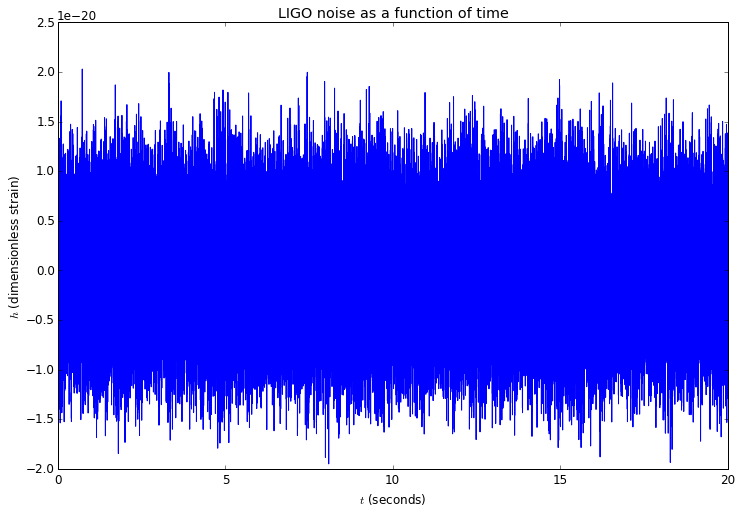

In [6]:
plot(LIGONoise.t, LIGONoise.data)
xlabel(r'$t$ (seconds)')
ylabel(r'$h$ (dimensionless strain)')
title(r'LIGO noise as a function of time');

In [7]:
LIGONoise.Audio()

The plot looks like a mess, and the data sounds like random noise.  Even worse, look at the size of the noise in the plot.  Our plot of the waveform above was for a system with total mass $100\,M_\odot$, and its amplitude was comparable to the size of the noise.  But more common systems have masses closer to $10\,M_\odot$; even their peak amplitude is smaller than the scale of the noise.  In fact, we can add one of our waveforms to the noise, and see what it looks (and sounds) like.  This simulates what the LIGO data would have been if there had been a merger while it was recorded:

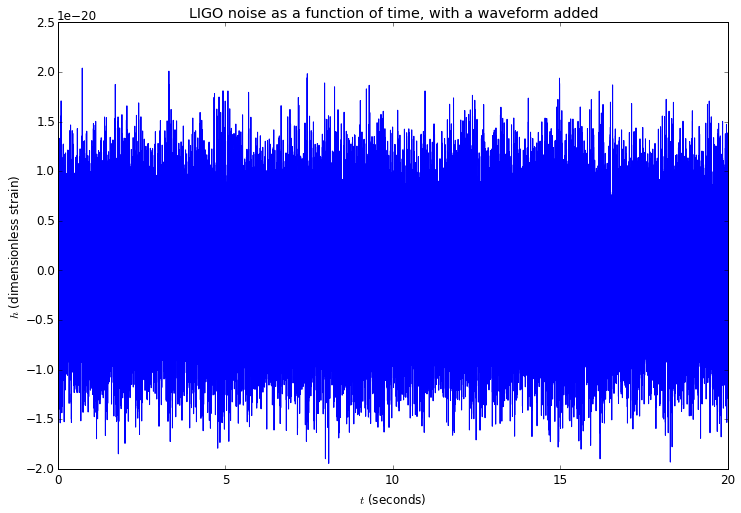

In [8]:
SimulatedSignal = Utils.Waveform(LIGONoise) # Make a copy of the noise
SimulatedSignal.data = LIGONoise.data + SpinningGW(5.0).data # Add a gravitational waveform to the copy's data
plot(SimulatedSignal.t, SimulatedSignal.data)
xlabel(r'$t$ (seconds)')
ylabel(r'$h$ (dimensionless strain)')
title(r'LIGO noise as a function of time, with a waveform added')
show() # show the plot before playing the sound
SimulatedSignal.Audio()

The waveform is indeed pretty much buried in the noise.  You could probably just hear the merger -- depending on the volume and the quality of your headsets -- but you couldn't hear it particularly clearly.  And you certainly couldn't see anything informative in the plot.  The point is you can't be sure what's noise and what's a real signal; maybe that thing you thought you heard was really just a blip in the data.  We know it wasn't just a blip, because we made the data.  But how would a GW astronomer know when looking at real data?

So we have a big question: How can we possibly measure gravitational waves in data that's so noisy?

<br /><br />

# 4. Fourier transforms

The first step in understanding how to measure a signal buried in noise is understanding that the noise may seem random, but it is random in very systematic ways.  When you listened to the noise alone, did you hear anything unsteady -- any clicks, pops, or generally sudden noises?  Probably not.  The noise didn't get louder or quieter.  It was basically what we would call "stationary".  In this case, it can be extremely useful to look at the noise in another way.

You may be familiar with the Fourier transform, which lets us write our noise function $n(t)$ as a sum of sines with different sizes, with all the frequencies that could be in the data:

$$
  n(t) = \sum_{f_i} \left[ \tilde{n}_{f_i} \sin(2\pi f_i t + \phi_{f_i}) \right].
$$

The terms to note in this equation are:

  - $f_i$, all frequencies that could be in the data
  - $\tilde{n}_{f_i}$, numbers telling us how much of that particular frequency is in our data (the amplitude)
  - $\phi_{f_i}$ are the numbers telling us just when that frequency hits its peak (the phase)

This conversion of $n(t)$ to $\tilde{n}_{f_i}$ and $\phi_{f_i}$ is called the "discrete Fourier transform" or "Fourier series".

There's also a very quick way of computing it called the "*fast* Fourier transform" (FFT).  In fact, in applications, this is by far the most useful way of doing Fourier transforms; if you're doing a Fourier transform on a computer, you almost certainly want to use the FFT to do it.  It's so common that you'll frequently hear people (including me) using "FFT" as a synonym for the discrete Fourier transform.

To take an example, suppose we have a pure tone &mdash; a signal $s(t)$ that is just one pure frequency.  Let's say that frequency is 440 Hz.  As a function of time, that signal will look and sound like this:

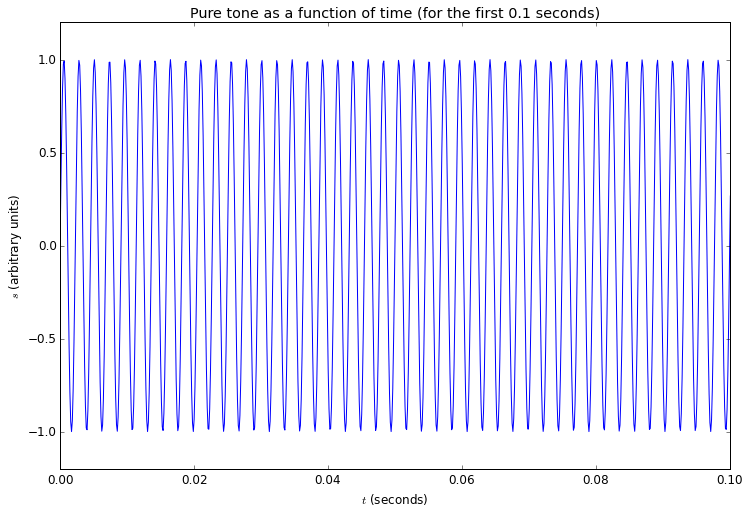

In [9]:
### Create Waveform object with 440 Hz signal
Frequency = 440.0 # Hz
Length = 3.0 # seconds
PureTone = Utils.Waveform()
PureTone.dt = 1.0/float(SamplingFrequency) # Time between samples
PureTone.N = int(SamplingFrequency*Length) # Number of samples
PureTone.data = sin(2*pi*Frequency*linspace(0.0, Length, PureTone.N, endpoint=False))

### Plot the first 0.1 seconds
figure()
plot(PureTone.t, PureTone.data);
ylim(-1.2,1.2)
xlim(0, 0.1)
xlabel("$t$ (seconds)")
ylabel("$s$ (arbitrary units)")
title("Pure tone as a function of time (for the first 0.1 seconds)")
show()

### Play it
PureTone.Audio()

When we take the Fourier transform, we'll just get $\tilde s_{\text{440 Hz}} = 1$, and all the other
$\tilde{s}_{f_i}=0$:

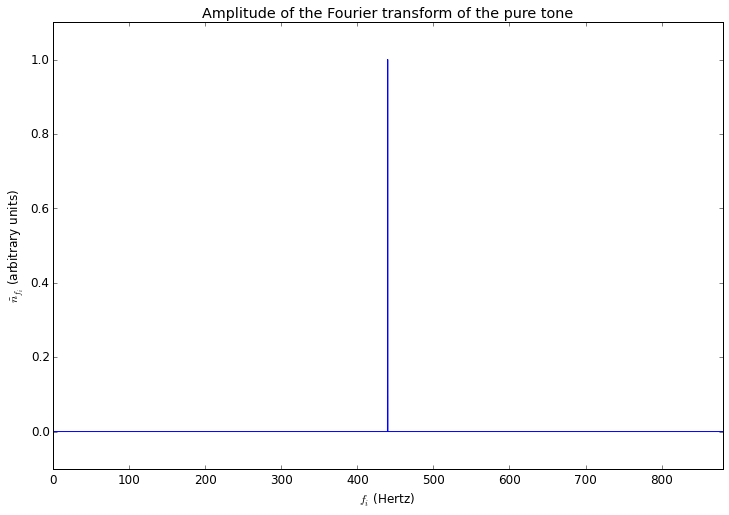

In [10]:
### Convert to frequency domain
PureToneFFT = np.fft.fft(PureTone.data) / PureTone.N # Take the Fourier transform
PureToneFrequencies = PureTone.f # Values of the f_i frequencies

### Now plot it:
figure()
PlotPoints = PureTone.N/2 # show first half of the data (positive frequencies)
plot(PureToneFrequencies[:PlotPoints], 2*abs(PureToneFFT[:PlotPoints]));
xlim(0,2*Frequency);
ylim(-0.1, 1.1);
xlabel("$f_i$ (Hertz)");
ylabel("$\\tilde{n}_{f_i}$ (arbitrary units)");
title("Amplitude of the Fourier transform of the pure tone");

Feel free to play with the parameters or add another pure tone, to see how you can change the sound and the FFT.

## 4.1 FFT of LIGO noise

Of course, sounds we encounter in the real world will be a mixture of many different frequencies, which means there will be lots of different spikes in the Fourier transform.  The noise recorded from LIGO has *lots* of different frequencies in it, so we'll see big spikes all over the place.  Let's take a look:

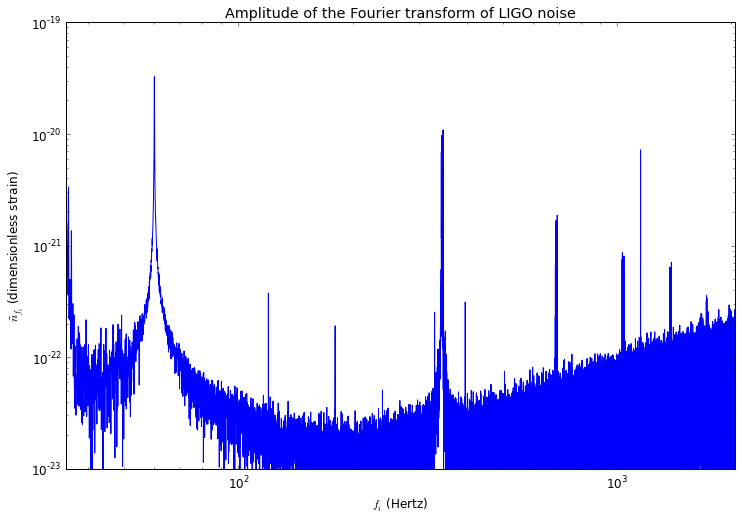

In [11]:
### Convert to frequency domain
fft_n = LIGONoise.fft() # Take the Fourier transform and save as 'NoiseFFT'
f_n = LIGONoise.f # Values of the f_i

### Now plot it:
loglog(f_n, abs(fft_n))
xlim(35.0,2048.0)
ylim(ymin=1e-23)
xlabel(r"$f_i$ (Hertz)")
ylabel(r"$\tilde{n}_{f_i}$ (dimensionless strain)")
title("Amplitude of the Fourier transform of LIGO noise");

The FFT is still pretty noisy, but we can now see some definite trends and interesting features.  What used to be a mess of data in the time domain has now taken a more structured form in the frequency domain.  The rough idea of detecting gravitational waves is to use the FFT to remove those big spikes from the data, and account for the broader trends.

## Questions

- Can you guess where the largest spike comes from?  [Hint: What is its frequency, and what else do you know that has that frequency?]
  - There are several very narrow spikes -- just one pixel wide.  Do you know where they come from?
  - Other than the largest spike and the narrow spikes, there is another group of spikes.  Can you discern a pattern in them?
  - If you ignore all the spikes, what general trends do you see?  Do you know what causes those trends?

## 4.2 FFT of waveforms

If we are to use the FFT of the noise, we'll also need the FFT of the gravitational waveform.  So let's compare the FFT of the waveform to the FFT of the noise:

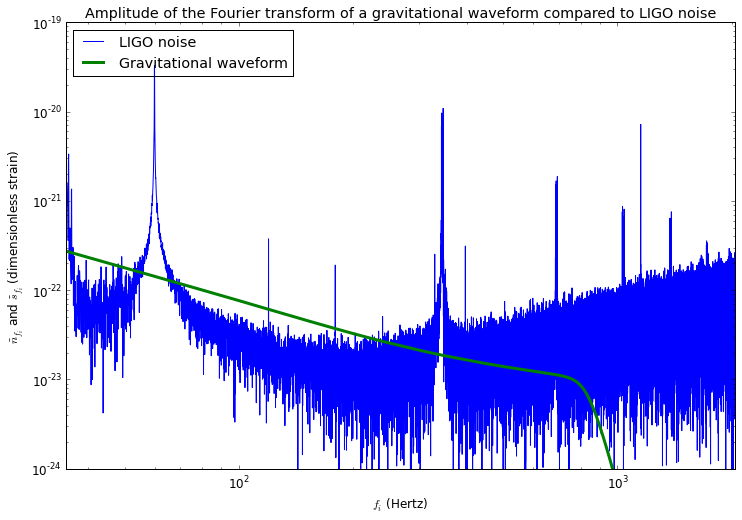

In [12]:
W = SpinningGW(25.0)
fft_s = W.fft()[1:W.N/2]
f_s = W.f[1:W.N/2]

loglog(f_n, abs(fft_n), label='LIGO noise')
loglog(f_s, abs(fft_s), label='Gravitational waveform', lw=3)
xlim(35.0, 2048.0)
ylim(ymin=1e-24)

xlabel(r"$f_i$ (Hertz)")
ylabel(r"$\tilde{n}_{f_i}$ and $\tilde{s}_{f_i}$ (dimensionless strain)")
legend(loc='upper left')
title("Amplitude of the Fourier transform of a gravitational waveform compared to LIGO noise");

The gravitational-wave signal starts off large at low frequencies, and slopes downward.  It starts to level off a little, but then falls off very sharply, rapidly dropping to zero amplitude.  The early downward slope corresponds to the long inspiral, the leveling out corresponds to the merger, and the rapid drop-off corresponds to ringdown.

## Questions

- When you listened to the gravitational wave, you heard that it was very quiet and deep in the beginning, and got louder and higher as time went on.  But if you look at the Fourier transform, it's bigger at low frequencies, and smaller at high frequencies.  How does this make sense?
  - How does the FFT of the waveform change as you change the mass?
  - Compared to the noise, the waveform still isn't very big.  What would the FFT look like if we combined the waveform with the noise to simulate a real signal?
  - Would you be able to tell just from that combined signal if you were measuring a black-hole merger or just seeing a blip in the data?
  - Would you be able to tell the difference between a spinning and a non-spinning system?  Could you measure the mass?

<br /><br /><br />

# 5. Matched filtering

Looking at the FFT gave us some insight into the noise and waveforms, but it's still not necessarily enough to tell us whether or not there is a signal in raw data from the detector, and certainly not enough to let us measure any waveforms we might find.  To do that, we'll need to get much better at filtering out the noise.  To do this, we measure the **"match"** between the data $d$ and template signal $s$, which filters the data using our knowledge of the expected signal and the typical noise in the detector, and then measures the total power in the filtered result.  If there's a lot of power, then the signal probably really was in our data.

An analogy might be helpful.  The bass and treble controls on a stereo control the deep and high-pitched sounds.  Sometimes, you'll find stereos with bass, treble, and mid-range -- the frequency ranges been split up into finer bins.  Fancier stereos will split them up into even finer bins, and have more controls.  You can adjust these "equalizer" controls to make certain frequency ranges louder or quieter, depending on whether you want to hear sounds in that frequency or not.

A Fourier transform divides the frequencies into as many bins as possible, and matched filtering adjusts each of the corresponding controls.  In fact, for any template signal, matched filtering gives you the best possible way to adjust all of those controls to hear that particular signal.

We start out with the amplitude of the Fourier transform of the data, $\tilde{d}_{f_i}$, and let's just think of one particular frequency for now.  If our expected signal $\tilde{s}_{f_i}$ is small, we want to ignore this part of the data; if $\tilde{s}_{f_i}$ is large, we want to accentuate this part of the data.  So the first step in our filter is to take the product

$$
  \tilde{d}_{f_i} \tilde{s}_{f_i}.
$$

If the signal is really in our data, then this picks out the meaningful part of that data.

On the other hand, if the detector's noise at this frequency is large, we expect the data to be large, but useless garbage.  So we want to ignore the data whenever there's a lot of noise.  To do that, we divide by the noise at this frequency $\tilde{n}_{f_i}$.  But we don't want to just level the playing field for the data; we want to really eliminate that bad data even from the signal &mdash; so we divide by *two* powers of the noise:

$$
  \frac{\tilde{d}_{f_i} \tilde{s}_{f_i}} {\tilde{n}_{f_i}^2}.
$$

Using the analogy with controls on the stereo, if the treble is really loud and noisy for example, we might turn it down so we can hear the other parts.  This is the same idea.

That isn't quite the whole story, though, because the Fourier transform really involves two pieces of information: the amplitude and the phase.  The phase $\phi_{f_i}$ tells us exactly where the sine with frequency $f_i$ hits its peak.  And if $d$ hits its peak when $s$ hits a trough, we don't really have the same signal.  So we bring in one more factor to our filter:

$$
  \frac{\tilde{d}_{f_i} \tilde{s}_{f_i}} {\tilde{n}_{f_i}^2} \cos \delta\phi_{f_i},
$$

where $\delta \phi_{f_i}$ is the difference in the phases $\phi_{f_i}$ of the Fourier transforms of $d$ and $s$ at this frequency.  Now, for each $f_i$, the quantity above is large whenever the noise is small and the expected signal agrees with the observed data &mdash; as long as our expected signal is really in the data.

And of course, all of this was just for one frequency, and we want all frequencies to be the same if the signal was really in the data.  So we sum the expression above for all frequencies we measured.

$$
  \sum_{f_{i}} \frac{\tilde{d}_{f_{i}}\, \tilde{s}_{f_{i}}} {\tilde{n}_{f_{i}}^{2}}\,
  \cos \delta\phi_{f_i}.
$$


Finally, we have no idea when a real astrophysical merger happened, so maybe our template was placed at the wrong time.  We can use the same template, but simply shift it by some time offset $\delta t$.  It turns out that this causes a very simple change to our formula, and we define the "match" to be

$$
  \big\langle d \big| s \big\rangle_{\delta t}
  = \sum_{f_{i}} \frac{\tilde{d}_{f_{i}}\, \tilde{s}_{f_{i}}} {\tilde{n}_{f_{i}}^{2}}\,
  \cos \left[ \delta\phi_{f_i} + f_{i}\, \delta t \right].
$$

This is the key quantity we measure when trying to detect gravitational waves.  Customarily, we also normalize the data so that the maximum possible value of the match is 1.

Once you've read this far, take the time to ask any questions and discuss this concept to make sure you understand what's going on.

## 5.1 Practice with simulated data

We can practice matched filtering by injecting a waveform into the LIGO noise to make simulated data (like we did above), and the searching with different templates to see if we can make a detection.  Just for fun, we'll shift the time a little bit, to see if we can still find it.  So we start off by making up a template and some simulated data.

In [13]:
# Make up our various signals
TemplateSignal = NonspinningGW(5.0) # Template signal
SimulatedSignal = Utils.Waveform(LIGONoise) # Make a copy of the noise
SimulatedSignal.data += NonspinningGW(5.0).Roll(1.5).data # Add a GW to the copy's data, and offset it by 1.5 seconds

First, let's see what the matched filter of the template looks like against the template itself.

<IPython.core.display.Latex object>

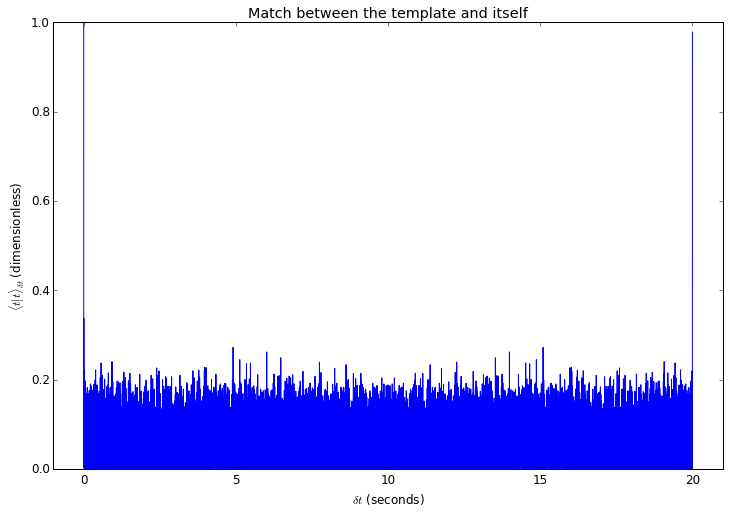

In [14]:
Match = abs(Utils.Match(TemplateSignal, TemplateSignal, LIGONoise))

max_index = argmax(Match)
max_value = Match[max_index]
max_time = TemplateSignal.t[max_index]
display(Latex(r'Maximum value of match is ${0:.5g}$ at $\delta t={1:.5g}$ seconds'.format(max_value, max_time)))

plot(TemplateSignal.t, Match)
xlim(TemplateSignal.t[0]-1.0,TemplateSignal.t[-1]+1.0)
xlabel(r'$\delta t$ (seconds)')
ylabel(r'$\langle t | t \rangle_{\delta t}$ (dimensionless)')
title(r'Match between the template and itself');

There are lots of little spikes, but the biggest one is way above the background (about 5 times larger than most spikes), at $\delta t=0$, and goes very close to 1.0 (which denotes a perfect match).  This makes sense, because we expect to get perfect overlap between the template and a copy of the template when we don't shift the copy in time at all.

Next, let's see what happens if we look for a match in pure noise.

<IPython.core.display.Latex object>

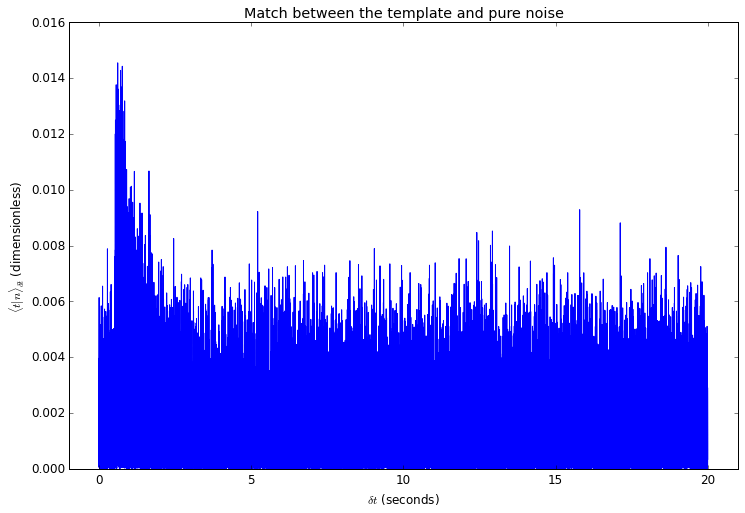

In [15]:
Match = abs(Utils.Match(LIGONoise, TemplateSignal, LIGONoise))

max_index = argmax(Match)
max_value = Match[max_index]
max_time = TemplateSignal.t[max_index]
display(Latex(r'Maximum value of match is ${0:.5g}$ at $\delta t={1:.5g}$ seconds'.format(max_value, max_time)))

plot(TemplateSignal.t, Match)
xlim(TemplateSignal.t[0]-1.0,TemplateSignal.t[-1]+1.0)
xlabel(r'$\delta t$ (seconds)')
ylabel(r'$\langle t | n \rangle_{\delta t}$ (dimensionless)')
title(r'Match between the template and pure noise');

Here, we see a maximum value (of course), but it's not very convincingly larger than the background.  It doesn't look purely random, because there's a bunch of larger spikes around $\delta t \approx 0.5$ seconds.  It's not too important, but that turns out to be related to the fact that the merger is 0.5 seconds before the end of the template.  The point is, if we saw this data in a gravitational-wave detector, we wouldn't get too excited; a match of this size is no reason to book your ticket to Stockholm.

Finally, we come to the comparison between our simulated signal and the template.

<IPython.core.display.Latex object>

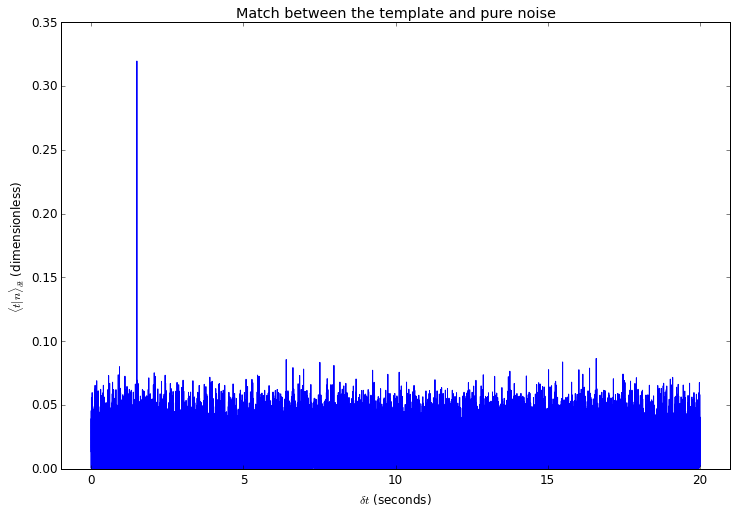

In [16]:
Match = abs(Utils.Match(SimulatedSignal, TemplateSignal, LIGONoise))

max_index = argmax(Match)
max_value = Match[max_index]
max_time = TemplateSignal.t[max_index]
display(Latex(r'Maximum value of match is ${0:.5g}$ at $\delta t={1:.5g}$ seconds'.format(max_value, max_time)))

plot(TemplateSignal.t, Match)
xlim(TemplateSignal.t[0]-1.0,TemplateSignal.t[-1]+1.0)
xlabel(r'$\delta t$ (seconds)')
ylabel(r'$\langle t | n \rangle_{\delta t}$ (dimensionless)')
title(r'Match between the template and pure noise');

Here, we see a pretty large spike.  It's not all the way up to 1.0, but it's still way above the others.  And it's at $\delta t = 1.5$ seconds, which is precisely the offset that we put into our simulated data.

## Questions

- If you didn't know that we had injected a signal into the data, but you saw the plot above, how could you argue that you had observed a gravitational wave?
  - What happens if you leave the injected waveform in the simulated data the same, but change the template you use to search for it?
  - Can you use the matched filter to tell whether a signal is spinning or non-spinning?
  - Can you use it to find the mass of the signal?

<br /><br /><br />

# 6. Running a search

Now, it's your turn to run a search and estimate parameters for whatever you detect.  Your challenge is to estimate the mass of the system, find the time offset, and figure out whether the system is spinning or not.

An unknown signal has been buried in noise for you.  Load it with the following command:

In [17]:
UnknownData = Utils.Waveform('Data/UnknownData.dat')

No two computers get the same data, so don't expect your neighbors' results to have any effect on you.  But to narrow things down for you, we've chosen the masses to be multiples of 5, from 5 to 100.

Now you can run your search.  You might want to use some code like the following.  You might also want to incorporate some of the code from above to make your job easier.

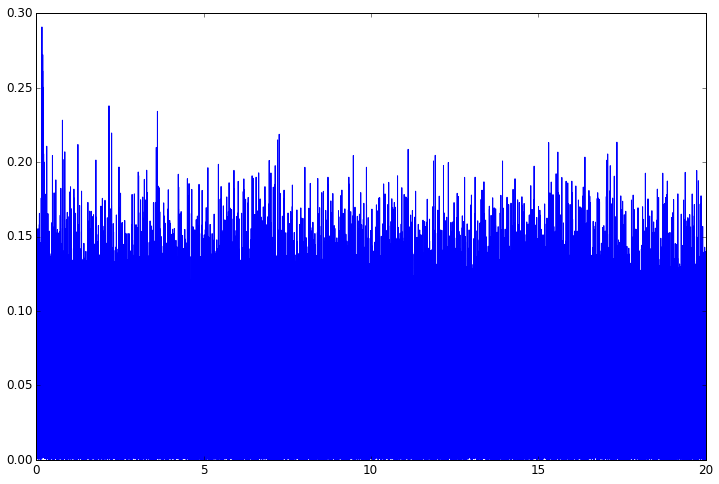

In [18]:
Match = abs(Utils.Match(UnknownData, SpinningGW(7.5), LIGONoise))

plot(UnknownData.t, Match);